## **Library Support**

In [219]:
import pandas as pd   
import numpy as np     
import matplotlib.pyplot as plt         
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re , string 
import warnings 
warnings.filterwarnings('ignore')

## **Load Dataset**

In [220]:
spam=pd.read_csv('spam_detection.csv',encoding='latin')

## **Basic Data Exploration**

#### **i) Head of DataFrame**

In [221]:
spam.iloc[:5]

,prediction,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### **ii) First Record in the DataFrame**

In [222]:
spam.iloc[0]['text']

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

#### **iii) Distribution of Target Variable**

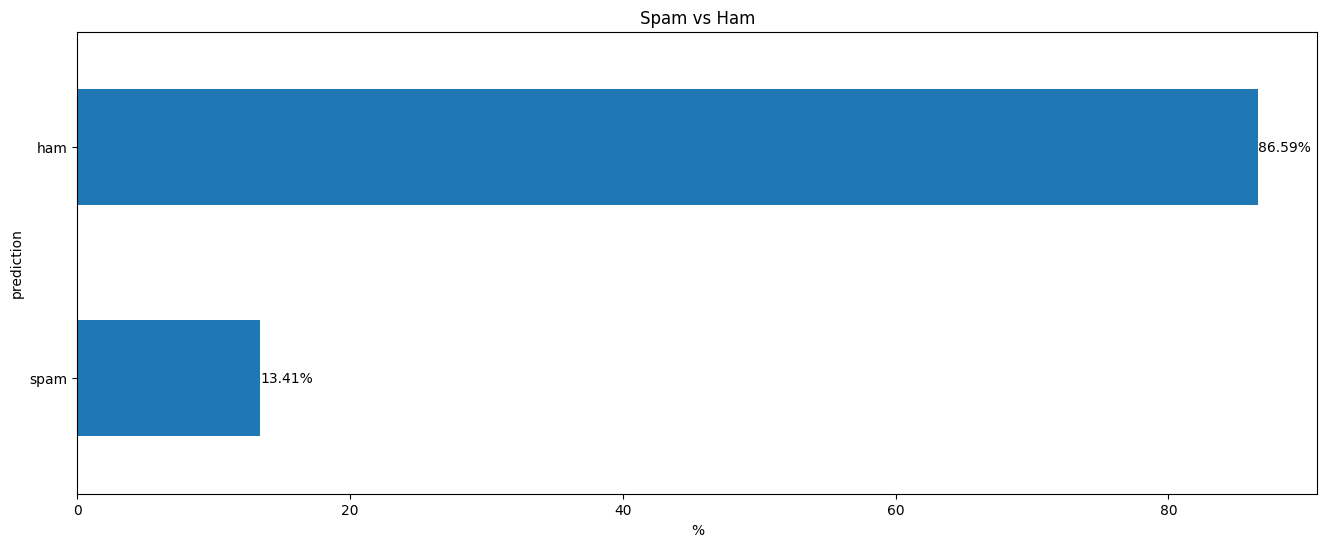

In [223]:
ax=(spam['prediction'].value_counts(normalize=True)*100).sort_values().plot(kind='barh',figsize=(16,6),title='Spam vs Ham',xlabel='%')
for a in ax.containers:
    plt.bar_label(a,fmt='%.2f%%')
plt.show()

**The data is greatly imbalanced.**

## **Data Preprocessing**

#### **Choosing Relevant Features**

In [224]:
spam=spam[['text','prediction']].copy()

#### **Create Function to display cleaning transformations**

In [225]:
def show(df):
    for i,text in enumerate(df):
        if i <= 4:
            print(text) 
        else:
            break

#### **i) Cleaning Text**

In [226]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [227]:
spam['text']=spam['text'].apply(clean_text)

In [228]:
show(spam['text'])

go until jurong point  crazy   available only in bugis n great world la e buffet    cine there got amore wat   
ok lar    joking wif u oni   
free entry in  a wkly comp to win fa cup final tkts  may   text fa to  to receive entry question std txt rate t c s apply  s
u dun say so early hor    u c already then say   
nah i don t think he goes to usf  he lives around here though


#### **ii) Tokenization**

In [229]:
spam['text']=spam['text'].apply(word_tokenize)

In [230]:
show(spam['text'])

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


#### **iii) Remove StopWords**

In [231]:
def remove_stopwords(text):
    stpw=set(stopwords.words('english'))
    filter_text=[word for word in text if word not in stpw]
    return filter_text

In [232]:
spam['text']=spam['text'].apply(remove_stopwords)

In [233]:
show(spam['text'])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


#### **iv) Lemmmatization**

In [234]:
lemmatizer=WordNetLemmatizer()

In [235]:
def lemmatize_word(text):
    lemm=[lemmatizer.lemmatize(word,pos='v') for word in text]
    return lemm  

In [236]:
spam['text']=spam['text'].apply(lemmatize_word)

In [237]:
show(spam['text'])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


## **Vectorization & Model Development**

#### **Library Support**

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder

#### **i) Create a Corpus of Lemmatized Words i.e `join the tokenized words into a full sentence`**

In [239]:
spam['text']=spam['text'].apply(lambda x : ' '.join([index for index in x]))

In [240]:
show(spam['text'])

go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


#### **ii) Split into Train / Test sets**

In [241]:
X=spam['text']
y=spam['prediction']

In [242]:
X_train,X_val,y_train,y_val=train_test_split(X,y,stratify=y,test_size=0.25,random_state=42)

#### **iii) Vectorize the transformed Corpus**

In [243]:
vect=TfidfVectorizer()
X_train=vect.fit_transform(X_train)
X_val=vect.transform(X_val)

#### **iv) Encode Target Variables**

In [244]:
label=LabelEncoder()
y_train=label.fit_transform(y_train)
y_val=label.transform(y_val)

#### **v) Model Building & Training**

**Library Support**

In [245]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,ConfusionMatrixDisplay

**Dictionary Reference for Classifiers**

In [246]:
class_ref={
    0 : 'XGBOOST',
    1 : 'Naive Bayes',
    2 : 'Random Forest',
    3 : 'GradientBoosting',
    4 : 'KNeighbors',
    5 : 'SVC'
}

**Build & Fit Models**

In [247]:
classifiers =[
    xgb.XGBClassifier(),
    MultinomialNB(), 
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(), 
    SVC()
    ]

for clf in classifiers:
    clf.fit(X_train, y_train)

**Cross Validation using `cross_val_score`**

In [248]:
for index,model in enumerate(classifiers):
    cv_score = cross_val_score(model,X_train,y_train,scoring="accuracy", cv=10)
    print(f"{class_ref[index]} : {cv_score.mean()*100:,.4f}")

XGBOOST : 97.5596
Naive Bayes : 96.5783
Random Forest : 97.8943
GradientBoosting : 96.8177
KNeighbors : 91.5774
SVC : 97.5594


#### **vi) Model Evaluation**

**Calculating Evaluation Metrics**

In [249]:
accuracy=[]
precision =[]
recall =[]
f1_score = []
confusion=[]

for clf in classifiers:
    y_pred = clf.predict(X_val)
    acc=accuracy_score(y_val,y_pred)
    pre = precision_score(y_val, y_pred)
    recal = recall_score(y_val, y_pred)
    f1 = metrics.f1_score(y_val, y_pred)
    conf=confusion_matrix(y_val,y_pred)

    #Appending metric scores
    accuracy.append(acc)
    precision.append(pre)
    recall.append(recal)
    f1_score.append(f1)
    confusion.append(conf)

**ii) Storing Calculated Metrics in a DataFrame**

In [250]:
data = {
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'F1score':f1_score
    }
evaluation = pd.DataFrame(data, index =['XGBOOST','NaiveBayes','RandomForest','GradientBoosting','KNeighbours','SVC'])

In [251]:
evaluation

,Accuracy,Precision,Recall,F1score
XGBOOST,0.973439,0.951807,0.844920,0.895184
NaiveBayes,0.963388,0.992754,0.732620,0.843077
RandomForest,0.973439,1.000000,0.802139,0.890208
GradientBoosting,0.967696,0.961039,0.791444,0.868035
KNeighbours,0.918880,1.000000,0.395722,0.567050
SVC,0.982053,1.000000,0.866310,0.928367


**iii) Confusion Matrix Display**

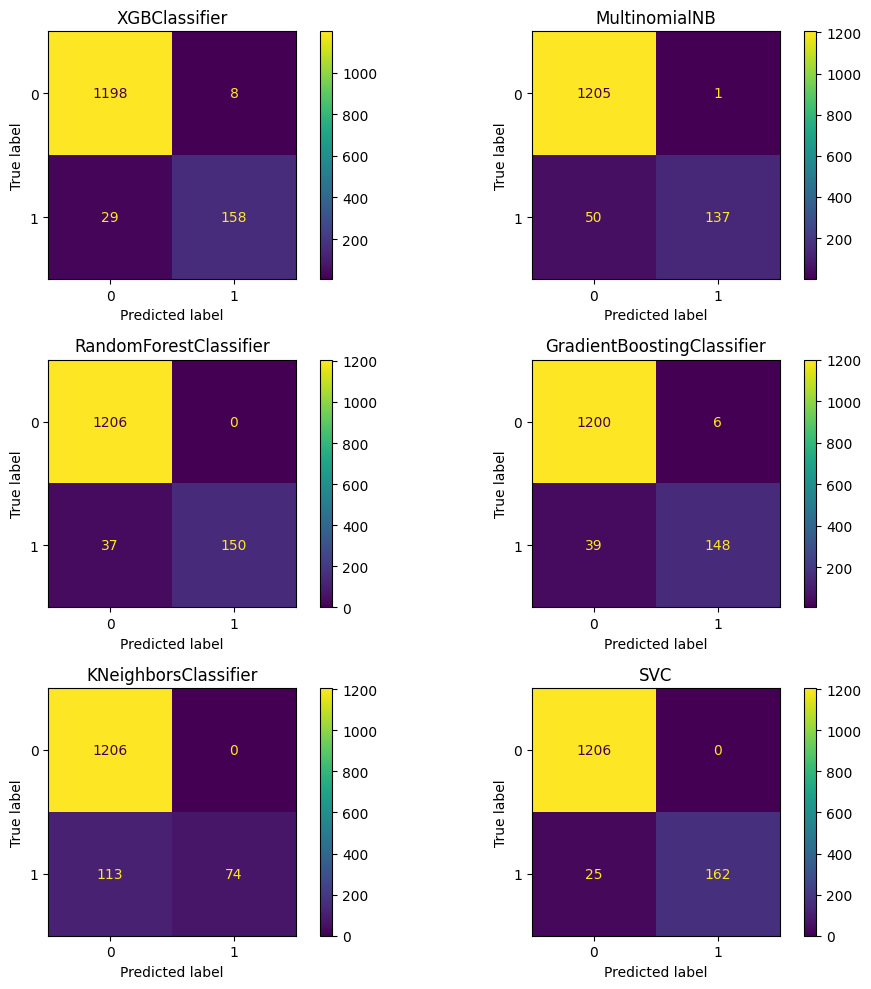

In [257]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

for cls, ax in zip(classifiers, axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(
                        cls, 
                        X_val, 
                        y_val, 
                        ax=ax  
                        )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

**`SVC performed exceptionally well` followed closely by `XGBClassifier`**